# FRUIT CLASSIFICATION

In this notebook, we apply machine learning techniques to perform fruit classification given images of different fruits as input.


**Table of Contents**

1. [Data Introduction](#1)<br>
2. [Binary-Class Classification](#2)<br>
    2.1. [SVM](#2.1)<br>
    2.2. [KNN](#2.2)<br>
    2.3. [RandomForest](#2.3)<br>
3. [Multi-Class Classification](#3)<br>
    3.1. [Tree-based Methods](#3.1)<br>
    3.2. [ConvNet and Transfer Learning](#3.2)<br>
4. [Conclusions](#4)<br>


**Main packages used**: *sklearn*, *keras*, *opencv*, *matplotlib*, *numpy*.

For a qucik **summary of the results** from tested methods, please jump to [Conclusions](#4).

## 1. Data Introduction<a id="1"></a>

The data set used in this study is from [kaggle](https://www.kaggle.com/moltean/fruits), version 2019.06.29.0.

The following fruits and are included: Apples (different varieties: Crimson Snow, Golden, Golden-Red, Granny Smith, Pink Lady, Red, Red Delicious), Apricot, Avocado, Avocado ripe, Banana (Yellow, Red, Lady Finger), Blueberry, Cactus fruit, Cantaloupe (2 varieties), Carambula, Cherry (different varieties, Rainier), Cherry Wax (Yellow, Red, Black), Chestnut, Clementine, Cocos, Dates, Granadilla, Grape (Blue, Pink, White (different varieties)), Grapefruit (Pink, White), Guava, Hazelnut, Huckleberry, Kiwi, Kaki, Kohlrabi, Kumsquats, Lemon (normal, Meyer), Lime, Lychee, Mandarine, Mango (Green, Red), Mangostan, Maracuja, Melon Piel de Sapo, Mulberry, Nectarine (Regular, Flat), Onion (Red, White), Orange, Papaya, Passion fruit, Peach (different varieties), Pepino, Pear (different varieties, Abate, Kaiser, Monster, Red, Williams), Pepper (Red, Green, Yellow), Physalis (normal, with Husk), Pineapple (normal, Mini), Pitahaya Red, Plum (different varieties), Pomegranate, Pomelo Sweetie, Potato (Red, White), Quince, Rambutan, Raspberry, Redcurrant, Salak, Strawberry (normal, Wedge), Tamarillo, Tangelo, Tomato (different varieties, Maroon, Cherry Red, Yellow), Walnut.

**Properties**<br>
- Total number of images: 75937.
- Training set size: 56781 images (one fruit or vegetable per image).
- Test set size: 19053 images (one fruit or vegetable per image).
- Number of classes: 111 (fruits and vegetables).
- Image size: 100 x 100 pixels.

**How they are made**<br>
- Fruits and vegetables were planted in the shaft of a low speed motor (3 rpm) and a short movie of 20 seconds was recorded.
- A Logitech C920 camera was used for filming the fruits.
- Behind the fruits, we placed a white sheet of paper as background.

**Reference**<br>
- Horea Muresan, Mihai Oltean, [Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning), Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.

**A couple of notes** at the beginning
- The dataset we have here are high quality (one item one image and clean background), making the task much easier than real-life fruit detection and classification. 
- Machine configuration: **4 CPUs**, **16G RAM**. To save memory, the images, while loaded, will be re-sized to 48 x 48 pixels.


First, let's **import library** and define a few helper functions to **load/plot** the data (pictures).

In [1]:
# import libraries
import scipy
import numpy as np 
import pandas as pd

import cv2     
import glob   # finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
import os
import time
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.multiclass import unique_labels

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics

In [3]:
# load the images using opencv
def getYourFruits(fruits, data_type, verbose = True):
    images = []
    labels = []
    path = "../input/*/fruits-360/" + data_type + "/"
    
    for i,f in enumerate(fruits):
        p = path + f
        j=0
        for image_path in glob.glob(os.path.join(p, "*.jpg")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)   # opencv default BGR pixel format
            images.append(image)
            labels.append(i)
            j += 1
        if verbose:
            print("There are {} {} images of {}".format(j, data_type, fruits[i]))
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# get the names of all the fruits
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("../input/*/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits
    

In [4]:
# function to plot the fruit images on a grid with labels (optional)
# default: labels are turned off
def plot_image_grid(images, y, ypred, nb_rows, nb_cols, figsize=(10, 10), print_y = False, print_ypred = False):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            # axs[i, j].xaxis.set_ticklabels([])
            # axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            title = ''
            if print_y:
                title += fruits[y[n]]
            if print_ypred:
                title += '\nPredicted = ' + fruits[ypred[n]]
            axs[i, j].set_title(title, fontsize=8)
            n += 1  
    plt.tight_layout()

## 2. Binary-Class Classification<a id="2"></a>

Before performing the classification for all the 111 types of fruits, let's select two of them and do a binary-class classification first.

**Load the data**    
The function defined above allows us to choose certain fruit types. For binary classification, let's use **Cocos** and **Pineapple** as examples because they have similar shapes and colors, thus may not be linearly separable.

In [5]:
# dimension used for each image, to save memory, 48 is used.
# each image is represented by a dim x dim x 3 matrix
dim = 48
#Choose your Fruits
fruits = ['Pineapple' , 'Cocos'] #Binary classification

#Get Images and Labels
X, y =  getYourFruits(fruits, 'Training')
X_test, y_test = getYourFruits(fruits, 'Test')

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

print("Shape of our training set = {}".format(X_train.shape))
print("Shape of our test set = {}".format(X_test.shape))

There are 490 Training images of Pineapple
There are 490 Training images of Cocos
There are 166 Test images of Pineapple
There are 166 Test images of Cocos
Shape of our training set = (980, 6912)
Shape of our test set = (332, 6912)


Each image is converted in a 48 x 48 x 3 numpy array (scaled and flatted in one single dimension) in order to perform classification. The original image size is 100 x 100 pixels, but here we use 48 x 48 instead to save memories. 

We can plot them to have a feeling of how this dataset look like.

Pineapple


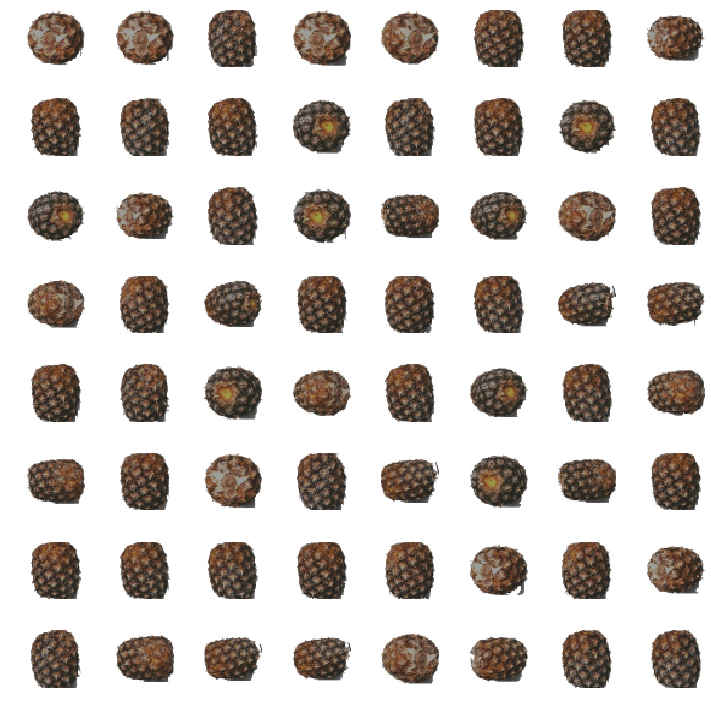

In [6]:
print(fruits[y[0]])
plot_image_grid(X[:64], y[:64], [], 8, 8)

Cocos


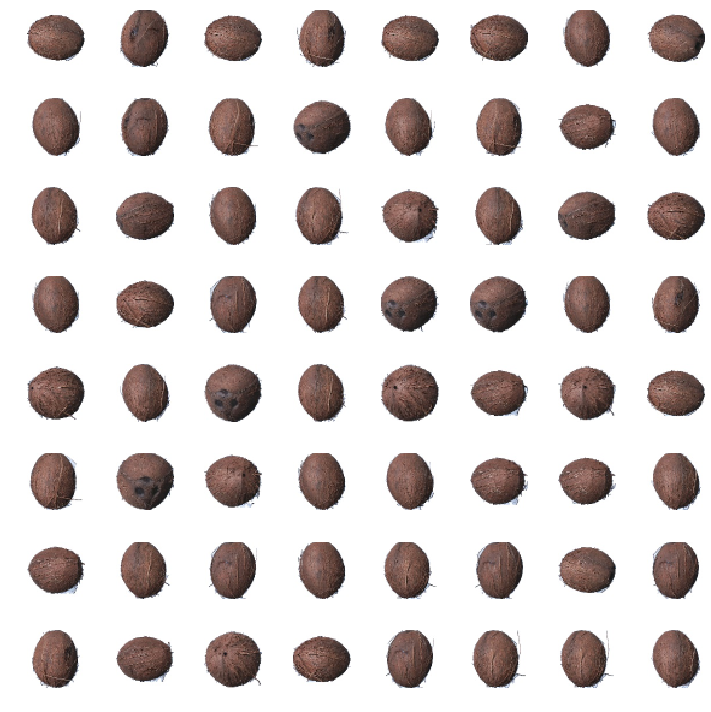

In [7]:
print(fruits[y[490]])
plot_image_grid(X[490:554], y[490:554], [], 8, 8)

We see pictures of **pineapples** and **cocos** shot from different angles. Although the pictures are resized, they are still very clear to us, i.e. humans should be able to easily tell apart pineapples and cocos from our dataset. This provides us a performance reference: **human-level accuracy = 1**.

For binary classification, the evaluation metrics we choose to use are: **accuracy**, **confusion matrix**, and **ROC-AUC**. The following function is provided by scikit-learn site ([link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)) to plot the confusion matrix.

In [8]:
# helper function to plot confusion matrix, copied from scikit-learn auto_examples
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

In [9]:
# helper function to report best scores from SearchCV
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Let's classify our dataset. 

**Methods** 
- Support Vector Machine (**SVM**)
- k-nearest neighbor (**K-NN**)
- One tree based methods, **Random Forest**

**Hyperparameter tunning**    
- For SVM and RandomForest, we used RandomizedSearchCV to optimize the hyperparameters
- For K-NN method, since we only tune the number nearest neighbors, a grid search is used.

### 2.1. SVM<a id="2.1"></a>

In [10]:
clf = SVC(probability=True)

n_iter_search = 10
# uses the scipy.stats module, which contains many useful distributions for sampling parameters
# such as expon, gamma, uniform or randint, etc
param_dist = {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['linear', 'rbf']}
r_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time.time()
r_search.fit(X_train, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(r_search.cv_results_, n_top=1)

RandomizedSearchCV took 1299.29 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'C': 4.590221827473119, 'gamma': 0.017737628797933377, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'C': 2.3943760357430524, 'gamma': 0.08463353436087233, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'C': 13.822281480345904, 'gamma': 0.06651920349357623, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'C': 5.530667139375616, 'gamma': 0.04247732171555721, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'C': 6.332931861431045, 'gamma': 0.10065252711382236, 'kernel': 'linear'}



Accuracy with SVM: 97.59%


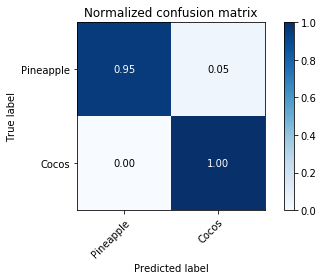

In [11]:
svm = r_search.best_estimator_
y_pred = svm.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_pred, y_test, classes=np.array(fruits), normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = svm.predict_proba(X_test)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_test, probs)
svm_auc = metrics.roc_auc_score(y_test, probs)

Using SVM, we achieved 97.59% accuary for the test set. From the confusion matrix, it can be seen that all the incorrectly labeled images are pineapple.

### 2.2. KNN<a id="2.2"></a>

Grid search took 72.02 seconds for 6 candidates parameter settings.


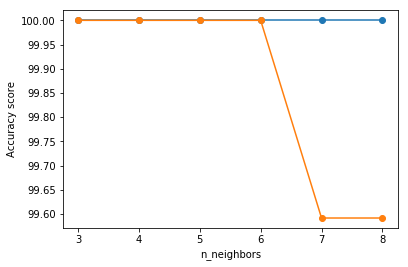

In [12]:
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y, random_state=7)
accuracy = []
n_neighbors = [3,4,5,6,7,8]
start = time.time()
for n_neighbor in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n_neighbor)
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_tr)
    p_train = metrics.accuracy_score(y_pred, y_tr) * 100
    y_pred = clf.predict(X_te)
    p_test = metrics.accuracy_score(y_pred, y_te) * 100
    accuracy.append([n_neighbor, p_train, p_test])

print("Grid search took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), len(n_neighbors)))

accuracy = np.array(accuracy)
plt.plot(accuracy[:,0], accuracy[:,1], marker='o', label='Fitting')
plt.plot(accuracy[:,0], accuracy[:,2], marker='o', label='Testing')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy score')
plt.show()

Accuracy with K-NN: 96.99%


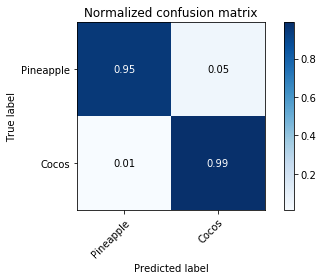

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y)
y_pred = knn.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=np.array(fruits), normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = knn.predict_proba(X_test)
probs = probs[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test, probs)
knn_auc = metrics.roc_auc_score(y_test, probs)


We used k=5 in the above model. For k>6, the model starts to overfit. Using KNN, we achieved 96.99% accuary for the test set. From the confusion matrix, it can be seen that the incorrectly labeled images come from both the pineapple and Cocos. Let's plot them. 

From the plot below, we can see for all the pineapples mislabeled as cocos have a shaded area on the right bottom corner. Not sure if this comes from the *lighting*, or some of the *images were in fact cut out of other image sources*.

In the test dataset, there are 10 samples are incorrectly labeled.


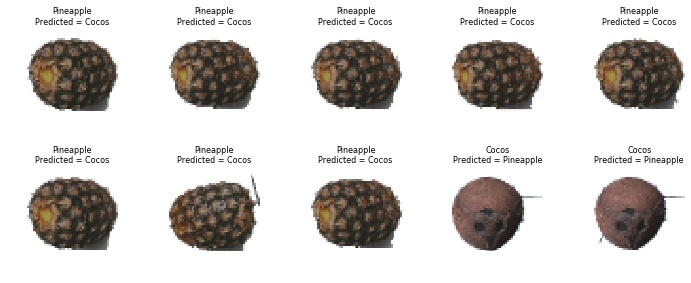

In [15]:
# plot the incorrectly labeled samples
wrong = []
for i in range(X_test.shape[0]):
    if y_test[i] != y_pred[i]:
        wrong.append(i)

print("In the test dataset, there are {} samples are incorrectly labeled.".format(len(wrong)))
if len(wrong)%2 == 0:
    nplot = len(wrong)
else:
    nplot = len(wrong) - 1

X_plot = np.array([X_tt[i] for i in wrong[:nplot]])
y_plot = np.array([y_test[i] for i in wrong[:nplot]])
y_pred_plot = np.array([y_pred[i] for i in wrong[:nplot]])
plot_image_grid(X_plot, y_plot, y_pred_plot, 2, nplot//2, figsize=(10, 4), print_y = True, print_ypred = True)

### 2.3. RandomForestClassifier<a id="2.3"></a>

In [14]:
clf = RandomForestClassifier(random_state=11)

n_iter_search = 20
# uses the scipy.stats module, which contains many useful distributions for sampling parameters
# such as expon, gamma, uniform or randint, etc
param_dist = {"max_depth": [3, None],
              "min_samples_split": scipy.stats.randint(2, 11),
              "criterion": ["gini", "entropy"],
              'n_estimators': scipy.stats.randint(50,100)}
r_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time.time()
r_search.fit(X_train, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(r_search.cv_results_, n_top=1)

RandomizedSearchCV took 116.58 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 3, 'n_estimators': 76}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 9, 'n_estimators': 80}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 6, 'n_estimators': 93}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 7, 'n_estimators': 86}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 64}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'criterion': 'gini', 'max_depth': None, 'min

Accuracy with RandomForest Tree: 97.59%


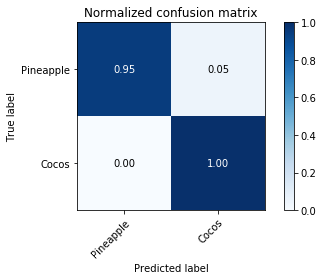

In [15]:
rf = r_search.best_estimator_
y_pred = rf.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with RandomForest Tree: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=np.array(fruits), normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = rf.predict_proba(X_test)
probs = probs[:, 1]
rf_fpr, rf_tpr, thresholds = metrics.roc_curve(y_test, probs)
rf_auc = metrics.roc_auc_score(y_test, probs)

Using Randomforest, we achieved 97.59% accuary for the test set, same as the SVM. And again, the incorrectly labeled images only come from the pineapple.

**ROC Curve**

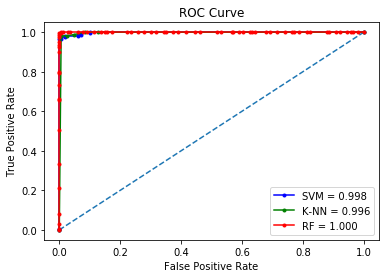

In [16]:
#ROC CURVE
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.3f' % svm_auc )
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.plot(rf_fpr, rf_tpr, 'r', marker='.',label = 'RF = %.3f' % rf_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

AUC for all three methods are close to 1. For the binary classification, SVM, KNN or tree-based ensemble method can do very well. 

## 3. Multi-Class Classification<a id="3"></a>

**Load the data**     
Let's now load all the fruits.

In [5]:
# fruits = ['Orange', 'Banana' , 'Strawberry', 'Apple Golden 1', 'Kiwi' , 'Lemon', 'Cocos' , 'Pineapple' , 'Peach', 'Cherry 1', 'Cherry 2', 'Mandarine']
fruits = getAllFruits() 
print("There are {} types of fruits in our dataset.".format(len(fruits)))

#Get Images and Labels
dim = 48
X, y =  getYourFruits(fruits, 'Training', verbose = False)
X_tt, y_test = getYourFruits(fruits, 'Test', verbose = False)

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X])
X_test = scaler.fit_transform([i.flatten() for i in X_tt])

print("Shape of our training set = {}".format(X_train.shape))
print("Shape of our test set = {}".format(X_test.shape))

There are 111 types of fruits in our dataset.
Shape of our training set = (56781, 6912)
Shape of our test set = (19053, 6912)


Each image is converted in a 48 x 48 x 3 numpy array (scaled and flatted in one single dimension) in order to perform classification.    
We can randomly select and plot some of them.

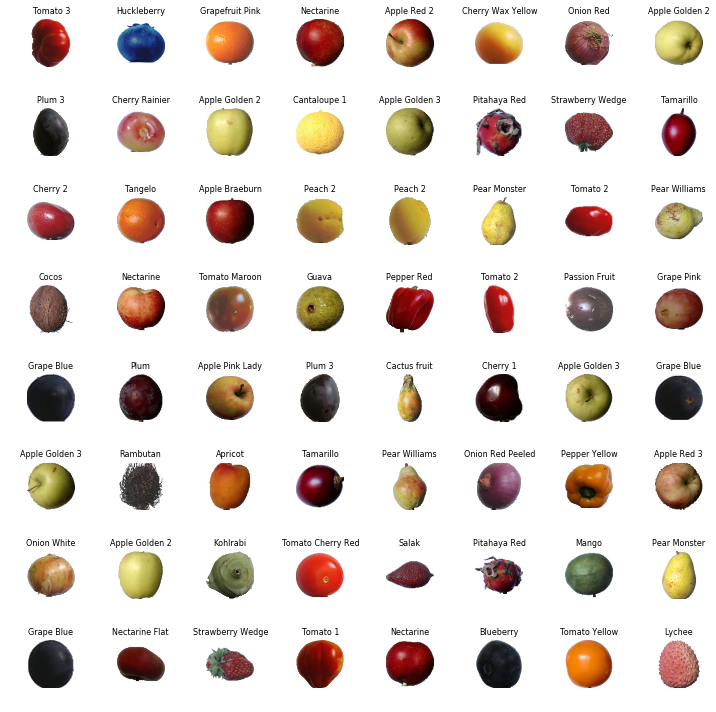

In [6]:
nplot = 64  # number of fruits to plot
selected = np.random.choice(range(X_train.shape[0]), size=nplot)
X_plot = np.array([X[i] for i in selected])
y_plot = np.array([y[i] for i in selected])
plot_image_grid(X_plot, y_plot, [], 8, 8, print_y = True)

We now have 111 types. This time, I would say the human-level performance will also slide away from being perfect. No way that we can correctly label all of them. 
- For apple alone, there are many types. Not sure we can distinguish Apple Golden 2 (e.g. row 2, col 3) and Apple Golden 3 (e.g. row 6, col 1).
- Different angle of a certain fruit can look very much like another, for instance, peach and apple.

Now, curious how accurate can machine perform?

### 3.1 Tree-based Methods<a id="3.1"></a>

Tree based methods (**Random Forest, Extra Tree**) are applied first.<br>
Reason not to use SVM and KNN: the fit time of **SVM** scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. **KNN**, also consumes too much memory and time when the training set is too big.

Here RandomizedSearch cross-validation is used to optimize the hyperparameters. For each method, we run 40 random searches.

#### 3.1.1. RandomForest

In [12]:
clf = RandomForestClassifier(random_state=11, n_jobs=-1)

n_iter_search = 40
# uses the scipy.stats module, which contains many useful distributions for sampling parameters
# such as expon, gamma, uniform or randint, etc
param_dist = {"max_depth": [3, 5, 10, 15, 20],
              "min_samples_split": scipy.stats.randint(2, 11),
              'n_estimators': scipy.stats.randint(50,100)}
r_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time.time()
r_search.fit(X_train, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(r_search.cv_results_, n_top=2)

RandomizedSearchCV took 10955.75 seconds for 40 candidates parameter settings.
Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 99}

Model with rank: 2
Mean validation score: 1.000 (std: 0.000)
Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 73}



In [13]:
rf = r_search.best_estimator_
y_pred = rf.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with RandomForestClassifier = {0:.2f}%".format(precision))

Accuracy with RandomForestClassifier = 95.44%


**Results**   
Good, for all 111 types of fruits and vegies, the accuracy goes above 95% for unseen dataset. Meanwhile, we can conclude that the model is overfitted. The validation/train score reaches 1.0 with *max_depth* of the trees set as 20 (maximum possible), while the test accuracy is 0.95.    
Some of the predictions are plotted below.

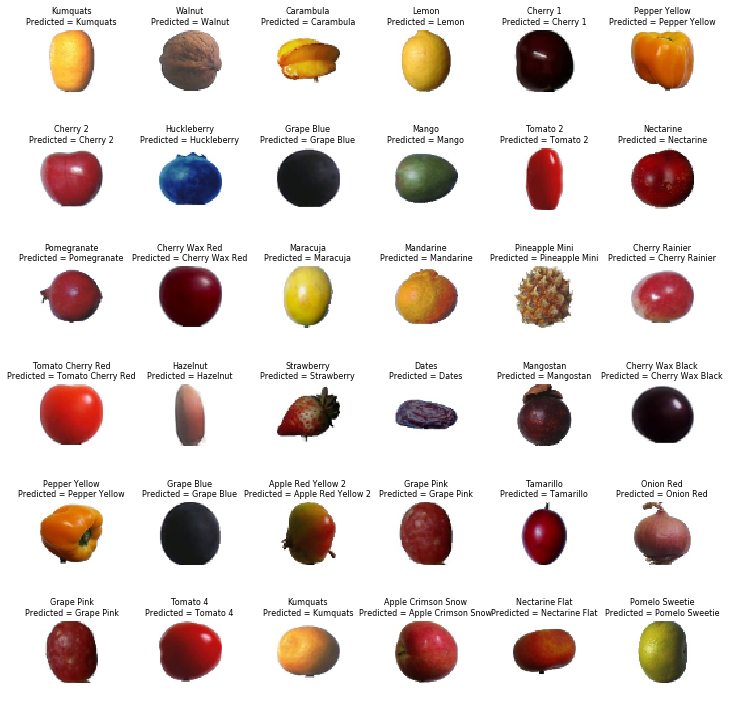

In [14]:
nplot = 36  # number of fruits to plot
selected = np.random.choice(range(X_tt.shape[0]), size=nplot)
X_plot = np.array([X_tt[i] for i in selected])
y_plot = np.array([y_test[i] for i in selected])
y_pred_plot = np.array([y_pred[i] for i in selected])
plot_image_grid(X_plot, y_plot, y_pred_plot, 6, 6, print_y = True, print_ypred = True)

Plot some mis-labeled images.

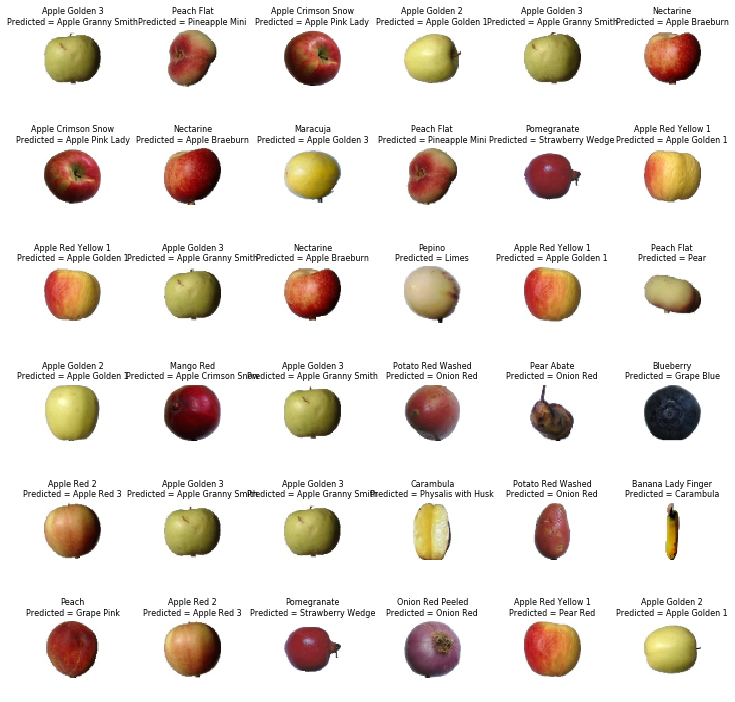

In [15]:
# plot some of the incorrectly labeled samples
wrong = []
for i in range(X_tt.shape[0]):
    if y_test[i] != y_pred[i]:
        wrong.append(i)

nplot = 36
selected = np.random.choice(wrong, size=nplot)
X_plot = np.array([X_tt[i] for i in selected])
y_plot = np.array([y_test[i] for i in selected])
y_pred_plot = np.array([y_pred[i] for i in selected])
plot_image_grid(X_plot, y_plot, y_pred_plot, 6, 6, print_y = True, print_ypred = True)


Well, looks like **different types of apples** contribute a large portion to the mislabeled images.

#### 3.1.2. ExtraTree

In [16]:
clf = ExtraTreesClassifier(random_state=11, n_jobs=-1)

n_iter_search = 40
# uses the scipy.stats module, which contains many useful distributions for sampling parameters
# such as expon, gamma, uniform or randint, etc
param_dist = {"max_depth": [3, 5, 10, 15, 20],
              "min_samples_split": scipy.stats.randint(2, 11),
              'n_estimators': scipy.stats.randint(50,100)}
r_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time.time()
r_search.fit(X_train, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(r_search.cv_results_, n_top=2)

RandomizedSearchCV took 8296.98 seconds for 40 candidates parameter settings.
Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 83}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 98}



In [17]:
et = r_search.best_estimator_
y_pred = et.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with ExtraTreesClassifer = {0:.2f}%".format(precision))

Accuracy with ExtraTreesClassifer = 96.58%


**Results**   
ExtraTree classifier produces better results! 96.58% accuracy for unseen dataset!    
Again, the model is overfitted. The validation/train score reaches 1.0 with *max_depth* of the trees set as 20 (maximum possible), while the test accuracy is 0.97.      
On the other hand, by comparing the RandomForest and ExtraTree methods, we notice **ExtraTree is clearly faster (also performs better)**. A detailed comparison between them can be found [here](https://www.thekerneltrip.com/statistics/random-forest-vs-extra-tree/).    
Some of the predictions are plotted below.

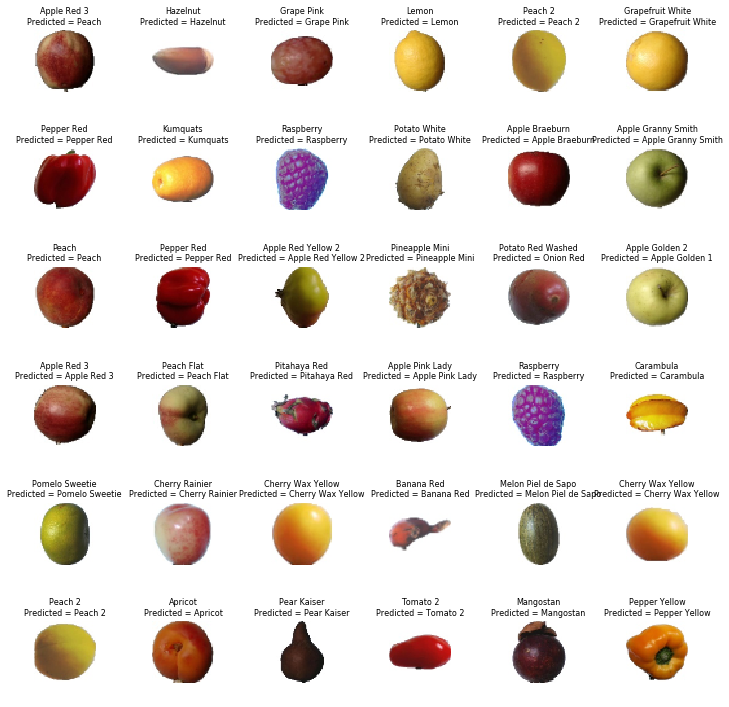

In [18]:
nplot = 36  # number of fruits to plot
selected = np.random.choice(range(X_tt.shape[0]), size=nplot)
X_plot = np.array([X_tt[i] for i in selected])
y_plot = np.array([y_test[i] for i in selected])
y_pred_plot = np.array([y_pred[i] for i in selected])
plot_image_grid(X_plot, y_plot, y_pred_plot, 6, 6, print_y = True, print_ypred = True)

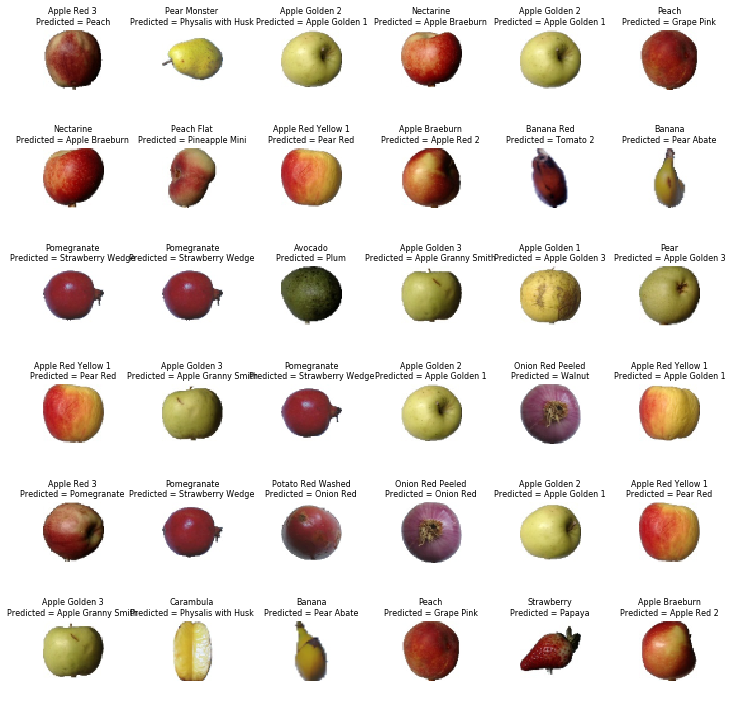

In [19]:
# plot some of the incorrectly labeled samples
wrong = []
for i in range(X_test.shape[0]):
    if y_test[i] != y_pred[i]:
        wrong.append(i)
nplot = 36
selected = np.random.choice(wrong, size=nplot)
X_plot = np.array([X_tt[i] for i in selected])
y_plot = np.array([y_test[i] for i in selected])
y_pred_plot = np.array([y_pred[i] for i in selected])
plot_image_grid(X_plot, y_plot, y_pred_plot, 6, 6, print_y = True, print_ypred = True)

Apple is also the major contribution to incorrectly labeled images.     
Overall, the tree based methods are doing decent on classifying the fruit images by achieving accuracy > 95% (prediction power). Not sure if human (those knowing all the fruits/vegetables) can correctly predict 95% of them (**without smelling/tasting them**).

### 3.2 ConvNet and Transfer Learning<a id="3.2"></a>
In the domain of computer vision, ConvNet is almost the default method nowadays because of its power. In the following section, 
- we'll build a simple CNN architecture and train it on the fruit images.
- apply transfer learning using well-known CNN architectures shared by the community (in particular, VGG19).

In [1]:
import scipy
import numpy as np 
import pandas as pd
import keras
import tensorflow as tf

import cv2     
import glob   # finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
import os
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Input
from keras.optimizers import RMSprop, Adamax

Using TensorFlow backend.


**Load the data**   
Load all the fruits.

In [5]:
# fruits = ['Orange', 'Banana' , 'Strawberry', 'Apple Golden 1', 'Kiwi' , 'Lemon', 'Cocos' , 'Pineapple' , 'Peach', 'Cherry 1', 'Cherry 2', 'Mandarine']
fruits = getAllFruits() 
print("There are {} types of fruits in our dataset.".format(len(fruits)))

#Get Images and Labels
dim = 48
X, y =  getYourFruits(fruits, 'Training', verbose = False)
X_test, y_test = getYourFruits(fruits, 'Test', verbose = False)
print("Shape of our training set = {}".format(X.shape))
print("Shape of our test set = {}".format(X_test.shape))

#Scale Data Images
X = X/255
X_test = X_test/255

There are 111 types of fruits in our dataset.
Shape of our training set = (56781, 48, 48, 3)
Shape of our test set = (19053, 48, 48, 3)


Each image is stored in a 48 x 48 x 3 numpy array (scaled by dividing 255). This time, we won't flatten them.

#### 3.2.1. Simple ConvNet

In [6]:
# Some data preparation:
# y labels need to be one-hot encoded
y_cnn = keras.utils.to_categorical(y, num_classes=len(fruits))   # one-hot encoding
y_test_cnn = keras.utils.to_categorical(y_test, num_classes=len(fruits))

# the training data should be randomly splitted and use part of it for the purpose of validation duing fitting
X_train, X_val, y_train, y_val = train_test_split(X, y_cnn, test_size=0.15)
print("Shape of cnn training set = {}, {}".format(X_train.shape, y_train.shape))
print("Shape of cnn validation set = {}, {}".format(X_val.shape, y_val.shape))

Shape of cnn training set = (48263, 48, 48, 3), (48263, 111)
Shape of cnn validation set = (8518, 48, 48, 3), (8518, 111)


In [7]:
# CNN, define model
def CNN_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(dim, dim, 3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    # model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(y_cnn.shape[1], activation='softmax'))
    # Compiling model
    model.compile(loss='categorical_crossentropy', optimizer=Adamax(), metrics=['accuracy'])
    
    return model

In [8]:
model_cnn = CNN_model()
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 128)         0         
__________

The model built above has ~386k parameters. Note that the number of none trainable weights of the model (128 here) comes from the BatchNormalization layers whose mean and variance vectors are updated via layer updates instead of backpropagation and therefore are considered as none trainable parameters.

In [9]:
start = time.time()
history = model_cnn.fit(X_train, y_train, batch_size=128, epochs=15, validation_data=(X_val, y_val))
print("Time used for the training = {}".format(time.time() - start))

Train on 48263 samples, validate on 8518 samples
Epoch 1/15
48263/48263 [==============================] - 157s 3ms/step - loss: 0.8202 - acc: 0.7859 - val_loss: 0.0473 - val_acc: 0.9887
Epoch 2/15
48263/48263 [==============================] - 156s 3ms/step - loss: 0.0824 - acc: 0.9764 - val_loss: 0.0293 - val_acc: 0.9917
Epoch 3/15
48263/48263 [==============================] - 156s 3ms/step - loss: 0.0436 - acc: 0.9874 - val_loss: 0.0030 - val_acc: 0.9995
Epoch 4/15
48263/48263 [==============================] - 158s 3ms/step - loss: 0.0287 - acc: 0.9918 - val_loss: 0.0505 - val_acc: 0.9786
Epoch 5/15
48263/48263 [==============================] - 156s 3ms/step - loss: 0.0160 - acc: 0.9956 - val_loss: 7.7584e-04 - val_acc: 0.9998
Epoch 6/15
48263/48263 [==============================] - 156s 3ms/step - loss: 0.0116 - acc: 0.9965 - val_loss: 5.9687e-04 - val_acc: 0.9999
Epoch 7/15
48263/48263 [==============================] - 157s 3ms/step - loss: 0.0110 - acc: 0.9969 - val_loss: 0.

15 epochs are trained and the result seems very good, both the training accuracy and validation accuracy nearly reach 1. If we plot the loss and accuracy evolution with epochs, we can get:

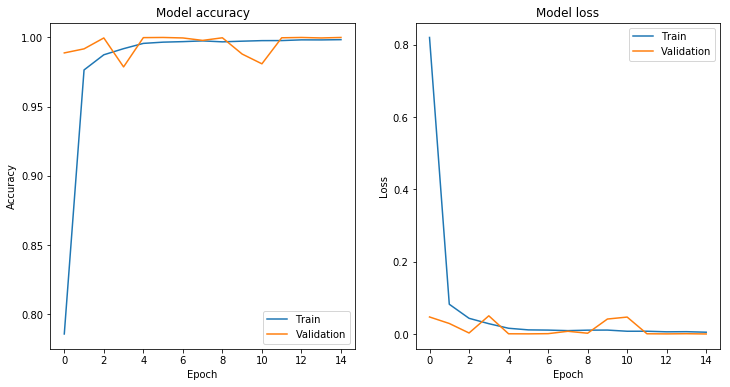

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
# Plot training & validation accuracy values
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [11]:
score = model_cnn.evaluate(X_test, y_test_cnn, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
y_pred = model_cnn.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

Test loss:  0.02629995876937949
Test accuracy:  0.99186479819451


**99.2% accuracy** for the unseen test set! Although there is still tiny overfitting from our CNN network, this performance is very impressive.

We can plot some of the predictions.

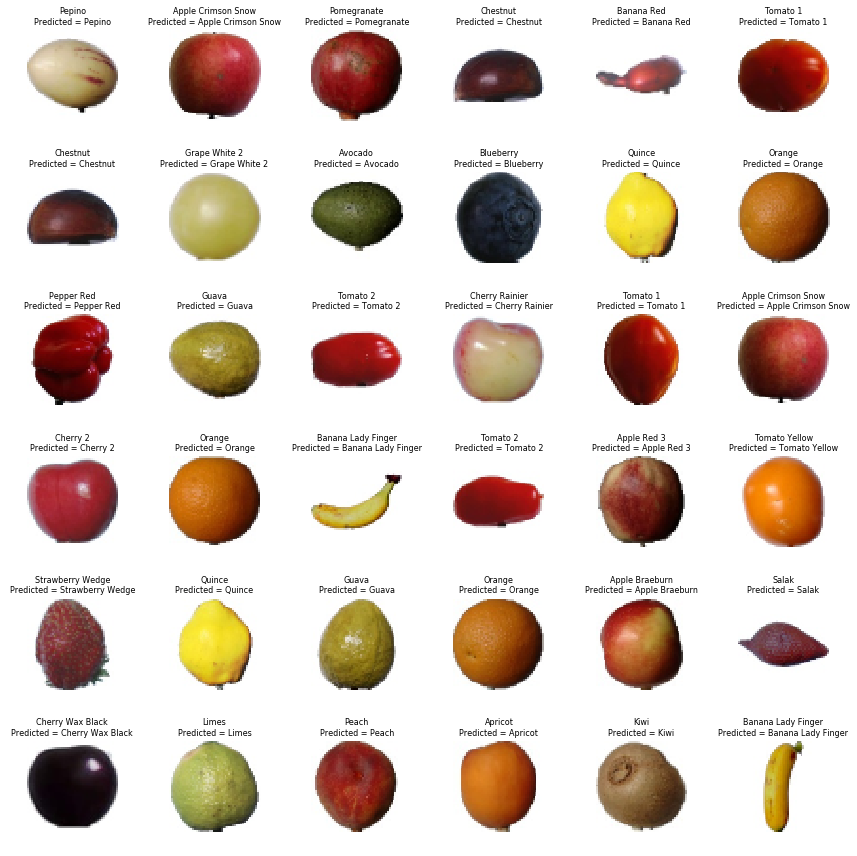

In [12]:
nplot = 36  # number of fruits to plot
selected = np.random.choice(range(X_test.shape[0]), size=nplot)
X_plot = np.array([X_test[i] for i in selected])
y_plot = np.array([y_test[i] for i in selected])
y_pred_plot = np.array([y_pred[i] for i in selected])

plot_image_grid(X_plot, y_plot, y_pred_plot, 6, 6, figsize=(12,12), print_y = True, print_ypred = True)

In the test dataset, there are 155 samples are incorrectly labeled.


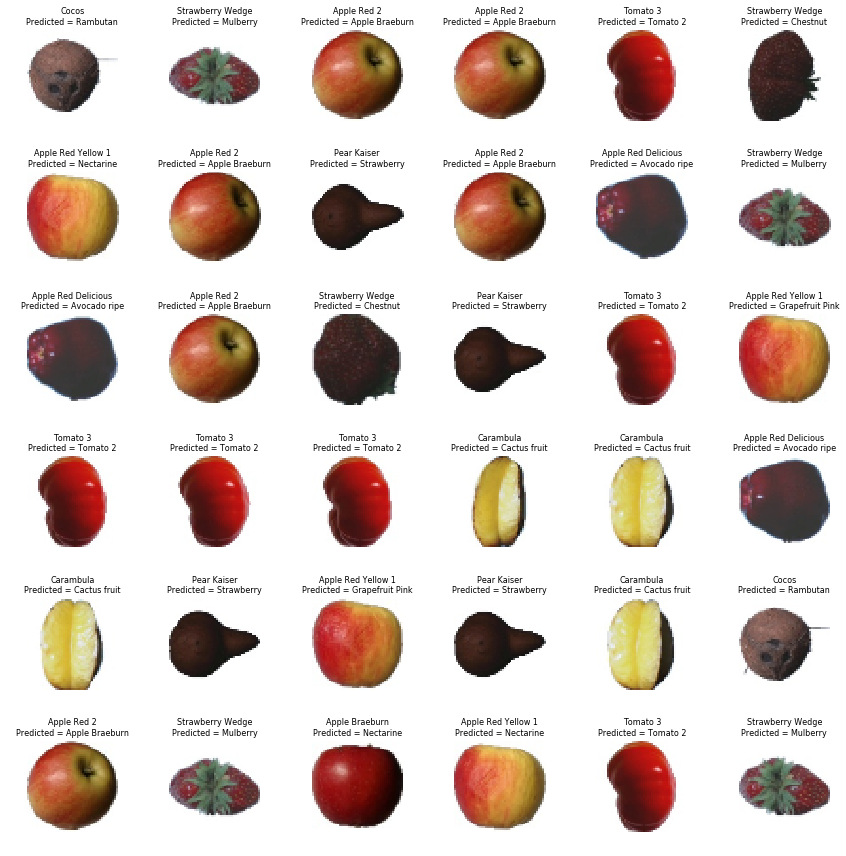

In [13]:
# plot some of the incorrectly labeled samples
wrong = []
for i in range(X_test.shape[0]):
    if y_test[i] != y_pred[i]:
        wrong.append(i)

print("In the test dataset, there are {} samples are incorrectly labeled.".format(len(wrong)))
nplot = 36
selected = np.random.choice(wrong, size=nplot)
X_plot = np.array([X_test[i] for i in selected])
y_plot = np.array([y_test[i] for i in selected])
y_pred_plot = np.array([y_pred[i] for i in selected])

plot_image_grid(X_plot, y_plot, y_pred_plot, 6, 6, figsize=(12,12), print_y = True, print_ypred = True)

Out of 19053 test images, 155 are mislabeled. Some are plotted above. Apple Red Yellow seems to be a trouble, but it does look like a nectarine! Also different types of tomato also seem to be troublesome.

**How about a smaller network?**
The following network reduces the last FC layer units (from 128 to 64), slightly smaller than the previous one. Let's see what happens.

In [14]:
# CNN, define model
def CNN_model2():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(dim, dim, 3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    # model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(y_cnn.shape[1], activation='softmax'))
    # Compiling model
    model.compile(loss='categorical_crossentropy', optimizer=Adamax(), metrics=['accuracy'])
    
    return model

model_cnn2 = CNN_model2()
model_cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 128)         0         
__________

In [15]:
start = time.time()
history2 = model_cnn2.fit(X_train, y_train, batch_size=128, epochs=15, validation_data=(X_val, y_val))
print("Time used for the training = {}".format(time.time() - start))

Train on 48263 samples, validate on 8518 samples
Epoch 1/15
48263/48263 [==============================] - 158s 3ms/step - loss: 1.2721 - acc: 0.6683 - val_loss: 0.0790 - val_acc: 0.9863
Epoch 2/15
48263/48263 [==============================] - 156s 3ms/step - loss: 0.2363 - acc: 0.9286 - val_loss: 0.0471 - val_acc: 0.9866
Epoch 3/15
48263/48263 [==============================] - 156s 3ms/step - loss: 0.1263 - acc: 0.9614 - val_loss: 0.0155 - val_acc: 0.9973
Epoch 4/15
48263/48263 [==============================] - 156s 3ms/step - loss: 0.0827 - acc: 0.9746 - val_loss: 0.0168 - val_acc: 0.9968
Epoch 5/15
48263/48263 [==============================] - 157s 3ms/step - loss: 0.0601 - acc: 0.9817 - val_loss: 0.0181 - val_acc: 0.9950
Epoch 6/15
48263/48263 [==============================] - 157s 3ms/step - loss: 0.0495 - acc: 0.9844 - val_loss: 0.0030 - val_acc: 0.9998
Epoch 7/15
48263/48263 [==============================] - 157s 3ms/step - loss: 0.0453 - acc: 0.9859 - val_loss: 0.0031 - v

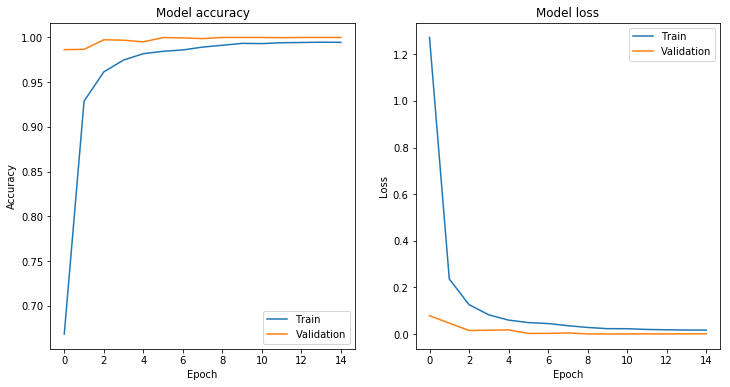

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
# Plot training & validation accuracy values
axs[0].plot(history2.history['acc'])
axs[0].plot(history2.history['val_acc'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot training & validation loss values
axs[1].plot(history2.history['loss'])
axs[1].plot(history2.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [17]:
score = model_cnn2.evaluate(X_test, y_test_cnn, verbose=0)
print('For a smaller model, ')
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

For a smaller model, 
Test loss:  0.055692046445705544
Test accuracy:  0.9826274077604369


The fitting of the smaller network doesn't seem to change much, both the train and validation reach about 100% accuracy, but the test set performance (98.3%) is slightly worse than the previous model.

#### 3.2.2. Transfer learning
In Keras Applications, there are many available deep learning models with pre-trained weights, which can be used for prediction, feature extraction, or fine-tuning (to get new models). Let's test one of them.

**VGG19**   
This model has 143,667,240 parameters with a depth of 26. We will get rid of the last 3 fully connected layers and add one by ourself, whose parameters are allowed to train.

In [18]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions

# exclude the top 3 FC layers at the top of the network
# and use the weights from pre-training on ImageNet
t_model = VGG19(include_top=False, weights='imagenet', input_shape=(dim, dim, 3))
for layer in t_model.layers:
    layer.trainable = False

80142336/80134624 [==============================] - 2s 0us/step


In [19]:
xx = Flatten()(t_model.output)
xx = Dense(128, activation='relu')(xx)
prediction = Dense(y_cnn.shape[1], activation='softmax')(xx)
vgg_model = Model(inputs=t_model.input, outputs=prediction)
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

Although the model is big, trainable parameters is only ~80k. Yet we'll see the training is still much more time consuming than the previously built simple models.

In [20]:
vgg_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [21]:
start = time.time()
history = vgg_model.fit(X_train, y_train, batch_size=128, epochs=15, validation_data=(X_val, y_val))
print("Time used for the training = {}".format(time.time() - start))

Train on 48263 samples, validate on 8518 samples
Epoch 1/15
48263/48263 [==============================] - 988s 20ms/step - loss: 2.1883 - acc: 0.5618 - val_loss: 1.0452 - val_acc: 0.7591
Epoch 2/15
48263/48263 [==============================] - 986s 20ms/step - loss: 0.6438 - acc: 0.8669 - val_loss: 0.5188 - val_acc: 0.8649
Epoch 3/15
48263/48263 [==============================] - 987s 20ms/step - loss: 0.3229 - acc: 0.9315 - val_loss: 0.2762 - val_acc: 0.9365
Epoch 4/15
48263/48263 [==============================] - 988s 20ms/step - loss: 0.1975 - acc: 0.9577 - val_loss: 0.1855 - val_acc: 0.9554
Epoch 5/15
48263/48263 [==============================] - 990s 21ms/step - loss: 0.1341 - acc: 0.9717 - val_loss: 0.1645 - val_acc: 0.9535
Epoch 6/15
48263/48263 [==============================] - 988s 20ms/step - loss: 0.0966 - acc: 0.9800 - val_loss: 0.1053 - val_acc: 0.9704
Epoch 7/15
48263/48263 [==============================] - 989s 20ms/step - loss: 0.0711 - acc: 0.9859 - val_loss: 0.0

In [22]:
score = vgg_model.evaluate(X_test, y_test_cnn, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Test loss:  0.32228376490177296
Test accuracy:  0.9299847792998478


The training and validation get quite high accuracy (nearly 100%), but the test accuracy is merely 93%. So it is quite overfit.

## Conclusions<a id="4"></a>

In this study, we applied different machine learning methods on the task of classifying fruit/vegetable images.    

**Result**

1. Binary-class Classification

| Method        | Accuracy (%)  | 
| ------------- |:-------------:| 
| SVM           | 97.59         | 
| KNN           | 96.99         | 
| RandomForest  | 97.59         | 

2. Multi-class Classification

| Method        | Accuracy (%)  | 
| ------------- |:-------------:| 
| RandomForest  | 95.44         | 
| ExtraTree     | 96.58         | 
| ConvNet (~380k params)          | 99.19         | 
| VGG19 (transfer learning)       | 93.00         |

**Summary**

- Traditional methods, particularly the tree based methods, perform decently on this task.


- ConvNet is (without doubt) superior, achieving a prediction accuracy of > 99% on 111 different kinds of fruits/vegetables (mostly likely outperforming human-level performance). This is also better than what was reported in the [reference paper](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning).


- This dataset is collected with extra care, targeting specifically at fruit/vegetable and all images in it have clean background. This is one of the reasons that all methods are performing incredibly well. Predicting fruit/vegetable from everyday images would be much more difficult.


- For simple tasks with enough data, transfer learning doesn't always outperform building models from scratch. Again, any real life problem could be unexpectly complicated, and transfer learning is always a good starting point.